In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.models import load_model


In [2]:
df = pd.read_csv("/Users/aayushrangra/Desktop/SolarForecasting/Sheet 1-2020.csv")
df

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45
0,2020,1,1,0,0,0,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,1,1,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,3,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,4,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2020,12,31,19,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8756,2020,12,31,20,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,2020,12,31,21,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,2020,12,31,22,0,0,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
columns_to_drop = ['Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44',
       'Unnamed: 45']
df.drop(columns=columns_to_drop, inplace=True)

In [4]:
df.insert(0, 'Datetime', pd.Series([float('nan')] * len(df)))

In [5]:
df = df[~df['Hour'].isin(list(range(0, 6)) + list(range(19, 24)))]

In [6]:
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_1105/3467001145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])


In [7]:
df['Datetime'].dt.strftime('%d-%m-%Y %H--00-00')

6       01-01-2020 06--00-00
7       01-01-2020 07--00-00
8       01-01-2020 08--00-00
9       01-01-2020 09--00-00
10      01-01-2020 10--00-00
                ...         
8750    31-12-2020 14--00-00
8751    31-12-2020 15--00-00
8752    31-12-2020 16--00-00
8753    31-12-2020 17--00-00
8754    31-12-2020 18--00-00
Name: Datetime, Length: 4745, dtype: object

In [8]:
df.drop(columns = ['Year', 'Month', 'Day', 'Hour','Minute'], inplace = True)

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_1105/3719660048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['Year', 'Month', 'Day', 'Hour','Minute'], inplace = True)


In [9]:
df

,Datetime,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,DNI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed
6,2020-01-01 06:00:00,0,0,0,7,0,0.338,99.43,1.0,4.6,-2.4,0,0,0,60.36,0.19,997,101,1.1
7,2020-01-01 07:00:00,12,27,13,7,5,0.340,87.20,1.0,5.6,-1.4,12,27,13,60.58,0.19,998,108,0.8
8,2020-01-01 08:00:00,112,217,164,4,5,0.341,76.23,1.0,8.3,-1.5,112,217,164,50.20,0.19,999,115,1.7
9,2020-01-01 09:00:00,191,369,339,1,0,0.342,66.36,1.0,11.1,-1.1,191,369,339,42.65,0.19,999,116,1.9
10,2020-01-01 10:00:00,237,466,482,3,5,0.343,58.38,1.0,15.3,-1.3,237,466,482,31.94,0.19,999,118,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8750,2020-12-31 14:00:00,163,631,480,7,3,0.263,59.94,0.4,21.4,-8.5,221,237,340,12.69,0.17,992,303,1.8
8751,2020-12-31 15:00:00,130,526,323,7,3,0.261,68.41,0.4,19.8,-7.7,155,168,217,14.94,0.17,992,303,1.2
8752,2020-12-31 16:00:00,74,330,140,7,3,0.259,78.60,0.4,15.5,-6.8,75,79,91,20.90,0.17,992,305,1.1
8753,2020-12-31 17:00:00,0,0,0,6,3,0.257,89.56,0.4,12.5,-7.5,0,0,0,24.13,0.17,992,306,1.4


In [10]:
df.index = pd.to_datetime(df['Datetime'], format='%d.%m.%Y %H:%M:%S')
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_1105/673535947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)


In [11]:
df

,Datetime,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,DNI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Seconds
Datetime,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,2020-01-01 06:00:00,0,0,0,7,0,0.338,99.43,1.0,4.6,-2.4,0,0,0,60.36,0.19,997,101,1.1,1.577858e+09
2020-01-01 07:00:00,2020-01-01 07:00:00,12,27,13,7,5,0.340,87.20,1.0,5.6,-1.4,12,27,13,60.58,0.19,998,108,0.8,1.577862e+09
2020-01-01 08:00:00,2020-01-01 08:00:00,112,217,164,4,5,0.341,76.23,1.0,8.3,-1.5,112,217,164,50.20,0.19,999,115,1.7,1.577866e+09
2020-01-01 09:00:00,2020-01-01 09:00:00,191,369,339,1,0,0.342,66.36,1.0,11.1,-1.1,191,369,339,42.65,0.19,999,116,1.9,1.577869e+09
2020-01-01 10:00:00,2020-01-01 10:00:00,237,466,482,3,5,0.343,58.38,1.0,15.3,-1.3,237,466,482,31.94,0.19,999,118,2.5,1.577873e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,2020-12-31 14:00:00,163,631,480,7,3,0.263,59.94,0.4,21.4,-8.5,221,237,340,12.69,0.17,992,303,1.8,1.609423e+09
2020-12-31 15:00:00,2020-12-31 15:00:00,130,526,323,7,3,0.261,68.41,0.4,19.8,-7.7,155,168,217,14.94,0.17,992,303,1.2,1.609427e+09
2020-12-31 16:00:00,2020-12-31 16:00:00,74,330,140,7,3,0.259,78.60,0.4,15.5,-6.8,75,79,91,20.90,0.17,992,305,1.1,1.609430e+09


In [12]:
day = 60*60*24
month = 30*day

df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Month sin'] = np.sin(df['Seconds'] * (2 * np.pi / month))
df['Month cos'] = np.cos(df['Seconds'] * (2 * np.pi / month))
df.head()

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_1105/83241650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_1105/83241650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_1105/83241650.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,Datetime,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,...,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Seconds,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,2020-01-01 06:00:00,0,0,0,7,0,0.338,99.43,1.0,4.6,...,60.36,0.19,997,101,1.1,1.577858e+09,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,2020-01-01 07:00:00,12,27,13,7,5,0.340,87.20,1.0,5.6,...,60.58,0.19,998,108,0.8,1.577862e+09,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,2020-01-01 08:00:00,112,217,164,4,5,0.341,76.23,1.0,8.3,...,50.20,0.19,999,115,1.7,1.577866e+09,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,2020-01-01 09:00:00,191,369,339,1,0,0.342,66.36,1.0,11.1,...,42.65,0.19,999,116,1.9,1.577869e+09,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,2020-01-01 10:00:00,237,466,482,3,5,0.343,58.38,1.0,15.3,...,31.94,0.19,999,118,2.5,1.577873e+09,0.500000,-8.660254e-01,-0.999848,-0.017452


In [13]:
df = df.drop('Seconds', axis=1)
df.head()

,Datetime,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,...,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,2020-01-01 06:00:00,0,0,0,7,0,0.338,99.43,1.0,4.6,...,0,60.36,0.19,997,101,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,2020-01-01 07:00:00,12,27,13,7,5,0.340,87.20,1.0,5.6,...,13,60.58,0.19,998,108,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,2020-01-01 08:00:00,112,217,164,4,5,0.341,76.23,1.0,8.3,...,164,50.20,0.19,999,115,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,2020-01-01 09:00:00,191,369,339,1,0,0.342,66.36,1.0,11.1,...,339,42.65,0.19,999,116,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,2020-01-01 10:00:00,237,466,482,3,5,0.343,58.38,1.0,15.3,...,482,31.94,0.19,999,118,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452


In [14]:
df.drop(columns = 'Datetime', inplace = True)

In [15]:
data = df

In [16]:
data.isna().sum()

Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Cloud Type            0
Fill Flag             0
Ozone                 0
Solar Zenith Angle    0
Precipitable Water    0
Temperature           0
Dew Point             0
DHI                   0
DNI                   0
GHI                   0
Relative Humidity     0
Surface Albedo        0
Pressure              0
Wind Direction        0
Wind Speed            0
Day sin               0
Day cos               0
Month sin             0
Month cos             0
dtype: int64

In [17]:
data.columns

Index(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Fill Flag', 'Ozone', 'Solar Zenith Angle', 'Precipitable Water',
       'Temperature', 'Dew Point', 'DHI', 'DNI', 'GHI', 'Relative Humidity',
       'Surface Albedo', 'Pressure', 'Wind Direction', 'Wind Speed', 'Day sin',
       'Day cos', 'Month sin', 'Month cos'],
      dtype='object')

Text(0.5, 1.0, 'Day cos')

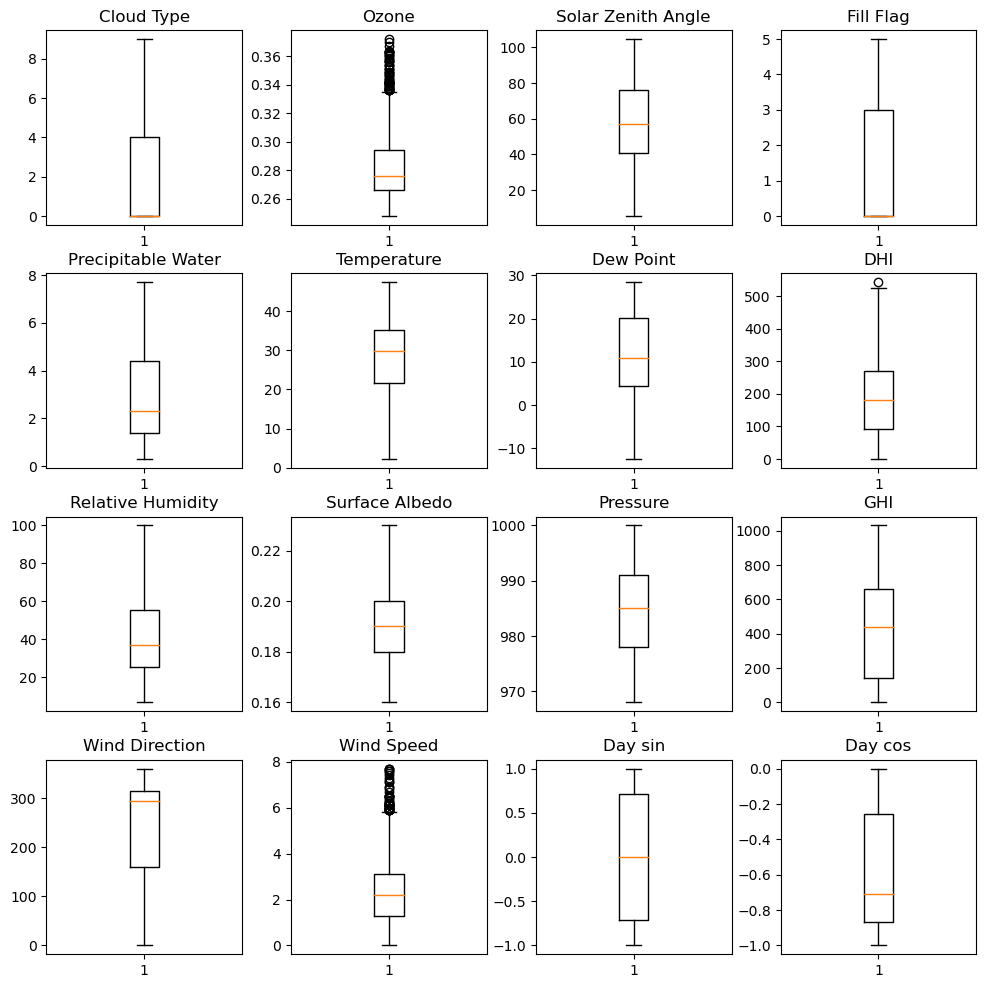

In [18]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

ax[0][0].boxplot(data['Cloud Type'])
ax[0][0].set_title('Cloud Type')

ax[0][1].boxplot(data['Ozone'])
ax[0][1].set_title('Ozone')

ax[0][2].boxplot(data['Solar Zenith Angle'])
ax[0][2].set_title('Solar Zenith Angle')

ax[0][3].boxplot(data['Fill Flag'])
ax[0][3].set_title('Fill Flag')

ax[1][0].boxplot(data['Precipitable Water'])
ax[1][0].set_title('Precipitable Water')

ax[1][1].boxplot(data['Temperature'])
ax[1][1].set_title('Temperature')

ax[1][2].boxplot(data['Dew Point'])
ax[1][2].set_title('Dew Point')

ax[1][3].boxplot(data['DHI'])
ax[1][3].set_title('DHI')

ax[2][0].boxplot(data['Relative Humidity'])
ax[2][0].set_title('Relative Humidity')

ax[2][1].boxplot(data['Surface Albedo'])
ax[2][1].set_title('Surface Albedo')

ax[2][2].boxplot(data['Pressure'])
ax[2][2].set_title('Pressure')

ax[2][3].boxplot(data['GHI'])
ax[2][3].set_title('GHI')

ax[3][0].boxplot(data['Wind Direction'])
ax[3][0].set_title('Wind Direction')

ax[3][1].boxplot(data['Wind Speed'])
ax[3][1].set_title('Wind Speed')

ax[3][2].boxplot(data['Day sin'])
ax[3][2].set_title('Day sin')

ax[3][3].boxplot(data['Day cos'])
ax[3][3].set_title('Day cos')

In [19]:
df.drop(columns = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Fill Flag', 'DHI', 'DNI'], inplace = True)

In [20]:
data 

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,7,0.338,99.43,1.0,4.6,-2.4,0,60.36,0.19,997,101,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,7,0.340,87.20,1.0,5.6,-1.4,13,60.58,0.19,998,108,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,4,0.341,76.23,1.0,8.3,-1.5,164,50.20,0.19,999,115,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,1,0.342,66.36,1.0,11.1,-1.1,339,42.65,0.19,999,116,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,3,0.343,58.38,1.0,15.3,-1.3,482,31.94,0.19,999,118,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7,0.263,59.94,0.4,21.4,-8.5,340,12.69,0.17,992,303,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7,0.261,68.41,0.4,19.8,-7.7,217,14.94,0.17,992,303,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7,0.259,78.60,0.4,15.5,-6.8,91,20.90,0.17,992,305,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


In [21]:
import numpy as np

for i in data.columns:  
    
    dt = np.array(data[i], dtype=float)  # Convert to float type
    Q1 = np.percentile(dt, 25)
    Q3 = np.percentile(dt, 75)
    IQ = Q3 - Q1
    upper = Q3 + 1.5 * IQ
    lower = Q1 - 1.5 * IQ

    dt[(dt > upper) | (dt < lower)] = np.nan
    data[i] = dt


In [22]:
data.isna().sum()

Cloud Type             0
Ozone                 60
Solar Zenith Angle     0
Precipitable Water     0
Temperature            0
Dew Point              0
GHI                    0
Relative Humidity      0
Surface Albedo         0
Pressure               0
Wind Direction         0
Wind Speed            56
Day sin                0
Day cos                0
Month sin              0
Month cos              0
dtype: int64

In [23]:
data=data.interpolate(method='linear', axis=0)
data.isna().sum()

Cloud Type             0
Ozone                 26
Solar Zenith Angle     0
Precipitable Water     0
Temperature            0
Dew Point              0
GHI                    0
Relative Humidity      0
Surface Albedo         0
Pressure               0
Wind Direction         0
Wind Speed             0
Day sin                0
Day cos                0
Month sin              0
Month cos              0
dtype: int64

Text(0.5, 1.0, 'Day cos')

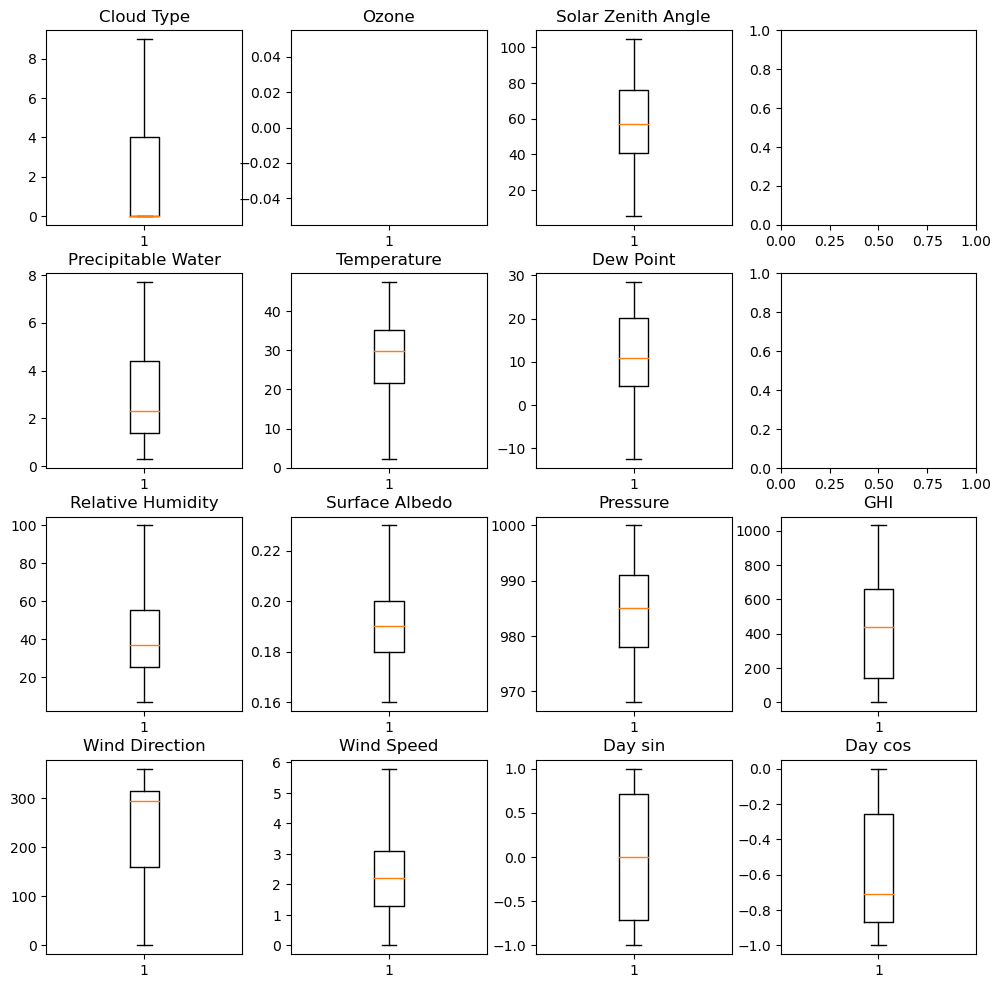

In [24]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

ax[0][0].boxplot(data['Cloud Type'])
ax[0][0].set_title('Cloud Type')

ax[0][1].boxplot(data['Ozone'])
ax[0][1].set_title('Ozone')

ax[0][2].boxplot(data['Solar Zenith Angle'])
ax[0][2].set_title('Solar Zenith Angle')

ax[1][0].boxplot(data['Precipitable Water'])
ax[1][0].set_title('Precipitable Water')

ax[1][1].boxplot(data['Temperature'])
ax[1][1].set_title('Temperature')

ax[1][2].boxplot(data['Dew Point'])
ax[1][2].set_title('Dew Point')

ax[2][0].boxplot(data['Relative Humidity'])
ax[2][0].set_title('Relative Humidity')

ax[2][1].boxplot(data['Surface Albedo'])
ax[2][1].set_title('Surface Albedo')

ax[2][2].boxplot(data['Pressure'])
ax[2][2].set_title('Pressure')

ax[2][3].boxplot(data['GHI'])
ax[2][3].set_title('GHI')

ax[3][0].boxplot(data['Wind Direction'])
ax[3][0].set_title('Wind Direction')

ax[3][1].boxplot(data['Wind Speed'])
ax[3][1].set_title('Wind Speed')

ax[3][2].boxplot(data['Day sin'])
ax[3][2].set_title('Day sin')

ax[3][3].boxplot(data['Day cos'])
ax[3][3].set_title('Day cos')

In [25]:
data

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,7.0,NaN,99.43,1.0,4.6,-2.4,0.0,60.36,0.19,997.0,101.0,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,7.0,NaN,87.20,1.0,5.6,-1.4,13.0,60.58,0.19,998.0,108.0,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,4.0,NaN,76.23,1.0,8.3,-1.5,164.0,50.20,0.19,999.0,115.0,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,1.0,NaN,66.36,1.0,11.1,-1.1,339.0,42.65,0.19,999.0,116.0,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,3.0,NaN,58.38,1.0,15.3,-1.3,482.0,31.94,0.19,999.0,118.0,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7.0,0.263,59.94,0.4,21.4,-8.5,340.0,12.69,0.17,992.0,303.0,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7.0,0.261,68.41,0.4,19.8,-7.7,217.0,14.94,0.17,992.0,303.0,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7.0,0.259,78.60,0.4,15.5,-6.8,91.0,20.90,0.17,992.0,305.0,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


In [26]:
data.dropna(inplace=True)

In [27]:
data

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,
2020-01-03 06:00:00,0.0,0.329,99.54,2.0,8.4,8.4,0.0,100.00,0.19,995.0,111.0,1.0,1.000000,1.636609e-12,-0.933580,0.358368
2020-01-03 07:00:00,0.0,0.327,87.30,2.0,10.4,10.4,11.0,99.77,0.19,996.0,121.0,1.2,0.965926,-2.588190e-01,-0.930418,0.366501
2020-01-03 08:00:00,0.0,0.324,76.29,2.0,12.9,10.7,153.0,86.57,0.19,996.0,129.0,1.8,0.866025,-5.000000e-01,-0.927184,0.374607
2020-01-03 09:00:00,0.0,0.321,66.38,2.0,16.1,11.1,322.0,72.33,0.19,997.0,129.0,2.0,0.707107,-7.071068e-01,-0.923880,0.382683
2020-01-03 10:00:00,0.0,0.318,58.34,2.0,18.4,11.3,464.0,63.28,0.19,996.0,126.0,1.7,0.500000,-8.660254e-01,-0.920505,0.390731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7.0,0.263,59.94,0.4,21.4,-8.5,340.0,12.69,0.17,992.0,303.0,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7.0,0.261,68.41,0.4,19.8,-7.7,217.0,14.94,0.17,992.0,303.0,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7.0,0.259,78.60,0.4,15.5,-6.8,91.0,20.90,0.17,992.0,305.0,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


Text(0.5, 1.0, 'Solar Irradiance Data')

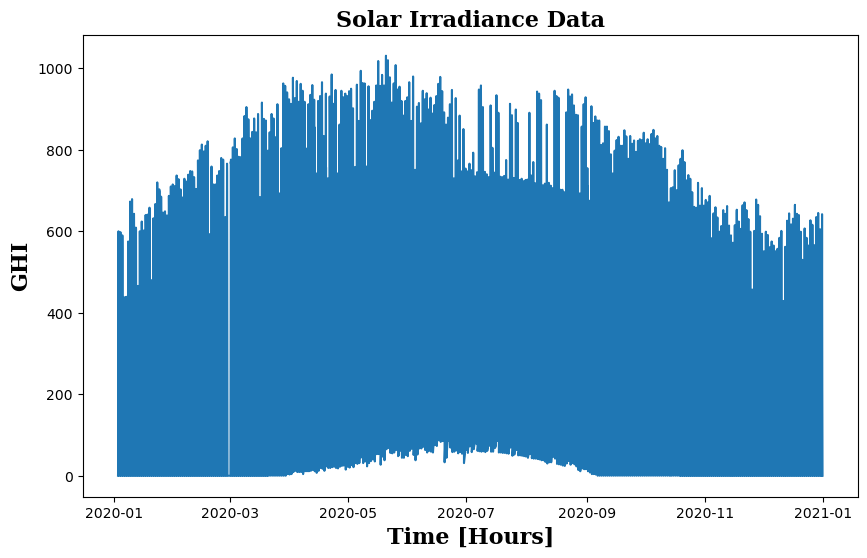

In [28]:
plt.figure(figsize=(10,6))
plt.plot(data['GHI'])

plt.xlabel('Time [Hours]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Solar Irradiance Data',fontsize=16, fontweight='bold',fontfamily='serif')

In [29]:
dt_arr=np.array(data)
dt_arr

array([[ 0.00000000e+00,  3.29000000e-01,  9.95400000e+01, ...,
         1.63660919e-12, -9.33580426e-01,  3.58367950e-01],
       [ 0.00000000e+00,  3.27000000e-01,  8.73000000e+01, ...,
        -2.58819045e-01, -9.30417568e-01,  3.66501227e-01],
       [ 0.00000000e+00,  3.24000000e-01,  7.62900000e+01, ...,
        -5.00000000e-01, -9.27183855e-01,  3.74606593e-01],
       ...,
       [ 7.00000000e+00,  2.59000000e-01,  7.86000000e+01, ...,
        -5.00000000e-01, -4.69471563e-01,  8.82947593e-01],
       [ 6.00000000e+00,  2.57000000e-01,  8.95600000e+01, ...,
        -2.58819045e-01, -4.61748613e-01,  8.87010833e-01],
       [ 7.00000000e+00,  2.55000000e-01,  1.02150000e+02, ...,
        -3.44870714e-12, -4.53990500e-01,  8.91006524e-01]])

In [30]:
from sklearn.preprocessing import minmax_scale
scaler=minmax_scale

In [31]:
for i in range (dt_arr.shape[1]):
    dt_arr[:,i]=scaler(dt_arr[:,i])

In [32]:
def create_dataset(data,time_window, label):   # time_window : The number of time steps you want the model to look back
                                               # label       : The column address of the target value
    X,Y=[],[]

    for i in range (len(data)-time_window-1) :
        
        a=data[i:i+time_window,0:data.shape[1]]
        X.append(a)
        Y.append(data[i+time_window,label])
        
    return (np.array(X),np.array(Y))

In [33]:
dt_train, d_test= dt_arr[0:round(0.75*len(dt_arr))] ,  dt_arr[round(0.75*len(dt_arr)):] 
dt_val, dt_test= d_test[0:round(0.5*len(d_test))], d_test[round(0.5*len(d_test)):] 

In [34]:
X_train,Y_train=create_dataset(dt_train, 7,1)
X_val, Y_val=create_dataset(dt_val,7,1)
X_test, Y_test=create_dataset(dt_test,7,1)

In [35]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((3531, 7, 16), (3531,), (582, 7, 16), (582,), (582, 7, 16), (582,))

In [ ]:
from tensorflow.keras.layers import Conv1D, LSTM

# Define input shape
input_shape = (7, 16)  # Replace input_dim with your input sequence length

model13 = Sequential()

# Add 1D CNN layers
model13.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model13.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model13.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))

# Add LSTM layers
model13.add(LSTM(units=64, return_sequences=True))
model13.add(LSTM(units=64, return_sequences=True))
model13.add(LSTM(units=64, return_sequences=False))

# Add Dense layers
model13.add(Dense(units=8, activation='relu'))
model13.add(Dense(units=1, activation='linear'))

model13.summary()

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp13 = ModelCheckpoint('model/model13/', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model13 = model13.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, callbacks=[cp13])

In [ ]:
Y_pred=model13.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
print ('R-Squared:',r2_score(Y_test,Y_pred))
print ('Mean squared error:', mean_squared_error (Y_test, Y_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred, Y_test)

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Y_pred)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions2(model, X, y, start=0, end=None):
    predictions = model.predict(X)
    GHI_preds = predictions.ravel()  # Ensure 1-dimensional array
    GHI_actuals = y.ravel()  # Ensure 1-dimensional array

    df1 = pd.DataFrame(data={'GHI Predictions': GHI_preds,
                             'GHI Actuals': GHI_actuals})
    print(df1)
    mse_GHI = mean_squared_error(GHI_actuals, GHI_preds)
    print("MSE for GHI Predictions:", mse_GHI)
    plt.plot(df1['GHI Predictions'][start:end])
    plt.plot(df1['GHI Actuals'][start:end])
    plt.legend(['Predicted', 'Actual'])
    plt.xlabel('Index')
    plt.ylabel('GHI')
    plt.title('GHI Predictions vs Actuals')
    plt.show()

    plt.scatter(GHI_preds, GHI_actuals)
    
    return df1[start:end]
    
    
def pltGraph(Model):
    RootMeanSquaredError = Model.history['root_mean_squared_error']
    val_RootMeanSquaredError = Model.history['val_root_mean_squared_error']
    loss = Model.history['loss'] 
    val_loss = Model.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(10), RootMeanSquaredError, label='Training RootMeanSquaredError') 
    plt.plot(range(10), val_RootMeanSquaredError, label='Validation RootMeanSquaredError') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation RootMeanSquaredError')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.plot(range(10), loss, label='Training Loss') 
    plt.plot(range(10), val_loss, label='Validation Loss') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

In [ ]:
plot_predictions2(model13, X_test, Y_test)

In [ ]:
import keras
from keras import layers
import tensorflow as tf


def lstm_attention_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # LSTM layer
    lstm = layers.LSTM(100, return_sequences=True)(inputs)
    
    # Attention mechanism
    attention = layers.Dense(1, activation='tanh')(lstm)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(100)(attention)
    attention = layers.Permute([2, 1])(attention)
    attention = layers.Multiply()([lstm, attention])
    attention = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)
    
    # Output layer
    outputs = layers.Dense(1)(attention)
    
    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [ ]:
model14=lstm_attention_model(input_shape=(7,16))

In [ ]:
model14.summary()

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp14 = ModelCheckpoint('model/model14/', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model14 = model14.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, callbacks=[cp14])

In [ ]:
Ypredd=model14.predict(X_test)

In [ ]:
print ('R-Squared:',r2_score(Y_test,Ypredd))
print ('Mean squared error:', mean_squared_error (Y_test, Ypredd))

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypredd)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    # Exclude observations where actual value is zero to avoid division by zero
    nonzero_indices = np.where(y_true != 0)
    y_true_nonzero = y_true[nonzero_indices]
    y_pred_nonzero = y_pred[nonzero_indices]
    
    # Calculate percentage error only for nonzero actual values
    percentage_error = (y_true_nonzero - y_pred_nonzero) / y_true_nonzero

    # Calculate MAPE and handle cases where there are no nonzero actual values
    if len(percentage_error) > 0:
        mape = np.mean(percentage_error) * 100
    else:
        mape = np.nan
    
    return mape

# Example usage:
# Assuming y_true contains the true target values and y_pred contains the predicted values
mape = mean_absolute_percentage_error(Y_test, Ypredd)
print("Mean Absolute Percentage Error (MAPE):", mape)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(Y_test, Y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

In [38]:
data

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,
2020-01-03 06:00:00,0.0,0.329,99.54,2.0,8.4,8.4,0.0,100.00,0.19,995.0,111.0,1.0,1.000000,1.636609e-12,-0.933580,0.358368
2020-01-03 07:00:00,0.0,0.327,87.30,2.0,10.4,10.4,11.0,99.77,0.19,996.0,121.0,1.2,0.965926,-2.588190e-01,-0.930418,0.366501
2020-01-03 08:00:00,0.0,0.324,76.29,2.0,12.9,10.7,153.0,86.57,0.19,996.0,129.0,1.8,0.866025,-5.000000e-01,-0.927184,0.374607
2020-01-03 09:00:00,0.0,0.321,66.38,2.0,16.1,11.1,322.0,72.33,0.19,997.0,129.0,2.0,0.707107,-7.071068e-01,-0.923880,0.382683
2020-01-03 10:00:00,0.0,0.318,58.34,2.0,18.4,11.3,464.0,63.28,0.19,996.0,126.0,1.7,0.500000,-8.660254e-01,-0.920505,0.390731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7.0,0.263,59.94,0.4,21.4,-8.5,340.0,12.69,0.17,992.0,303.0,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7.0,0.261,68.41,0.4,19.8,-7.7,217.0,14.94,0.17,992.0,303.0,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7.0,0.259,78.60,0.4,15.5,-6.8,91.0,20.90,0.17,992.0,305.0,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


In [39]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((3531, 7, 16), (3531,), (582, 7, 16), (582,), (582, 7, 16), (582,))

In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape

# Create the Sequential model
# model15 = Sequential()

# model15.add(InputLayer((7, 16)))
# # 1D CNN layers
# model15.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(7, 16)))
# model15.add(MaxPooling1D(pool_size=2, padding='same'))
# model15.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
# model15.add(MaxPooling1D(pool_size=2, padding='same'))
# model15.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
# model15.add(MaxPooling1D(pool_size=2, padding='same'))
# model15.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))

# # LSTM layers
# model15.add(LSTM(units=64, return_sequences=True))
# model15.add(LSTM(units=64, return_sequences=True))
# model15.add(LSTM(units=64, return_sequences=True))

# # Reshape for 2D CNN layer
# model15.add(Reshape((64, 1, 1)))  # reshape to (batch_size, 64, 1, 1)

# # 2D CNN layers
# model15.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# model15.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model15.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# model15.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# # Flatten layer
# model15.add(Flatten())

# # Output layer
# model15.add(Dense(units=1, activation='linear'))




model15 = Sequential()

model15.add(InputLayer((7, 16)))
# 1D CNN layers
model15.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(7, 16)))
model15.add(MaxPooling1D(pool_size=2, padding='same'))
model15.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model15.add(MaxPooling1D(pool_size=2, padding='same'))

# LSTM layers
model15.add(LSTM(units=64, return_sequences=False))

# Reshape for 2D CNN layer
model15.add(Reshape((64, 1, 1)))  # reshape to (batch_size, 64, 1, 1)

# 2D CNN layers
model15.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model15.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten layer
model15.add(Flatten())

# Output layer
model15.add(Dense(units=1, activation='linear'))

# Display model summary
model15.summary()


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_130 (Conv1D)         (None, 7, 32)             1568      
                                                                 
 max_pooling1d_107 (MaxPool  (None, 4, 32)             0         
 ing1D)                                                          
                                                                 
 conv1d_131 (Conv1D)         (None, 4, 64)             6208      
                                                                 
 max_pooling1d_108 (MaxPool  (None, 2, 64)             0         
 ing1D)                                                          
                                                                 
 lstm_103 (LSTM)             (None, 64)                33024     
                                                                 
 reshape_43 (Reshape)        (None, 64, 1, 1)        

In [102]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp15 = ModelCheckpoint('model/model15/', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model15 = model15.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, callbacks=[cp15])

Epoch 1/10
111/111 [==============================] - ETA: 0s - loss: 0.1096 - root_mean_squared_error: 0.3310INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 4s 31ms/step - loss: 0.1096 - root_mean_squared_error: 0.3310 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2116
Epoch 2/10
111/111 [==============================] - 1s 13ms/step - loss: 0.0279 - root_mean_squared_error: 0.1669 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2279
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.1165INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 3s 23ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1911
Epoch 4/10
110/111 [============================>.] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0887INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 2s 22ms/step - loss: 0.0079 - root_mean_squared_error: 0.0886 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 5/10
111/111 [==============================] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0703INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 2s 23ms/step - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 6/10
111/111 [==============================] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0589INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 3s 30ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 7/10
111/111 [==============================] - 1s 13ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 8/10
109/111 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0489INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 2s 22ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 9/10
111/111 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0469INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


111/111 [==============================] - 3s 23ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0505
Epoch 10/10
111/111 [==============================] - 1s 12ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0515


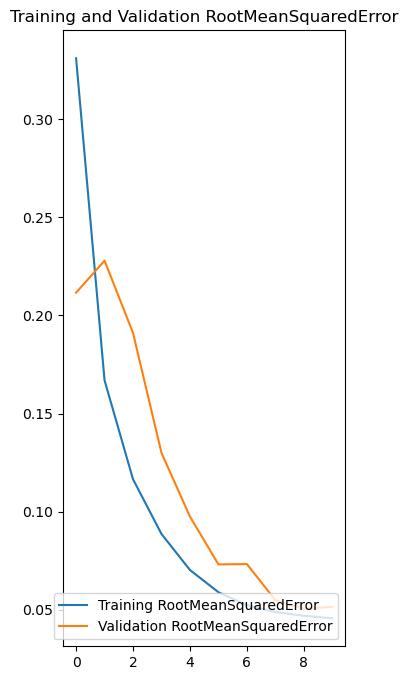

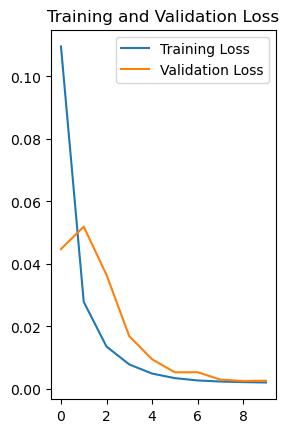

In [103]:
pltGraph(Model15)

19/19 [==============================] - 0s 7ms/step
     GHI Predictions  GHI Actuals
0           0.212085     0.264368
1           0.254467     0.264368
2           0.249494     0.275862
3           0.255923     0.275862
4           0.260845     0.275862
..               ...          ...
577         0.161776     0.183908
578         0.149103     0.172414
579         0.162270     0.149425
580         0.152454     0.126437
581         0.157270     0.103448

[582 rows x 2 columns]
MSE for GHI Predictions: 0.0027876102412409706


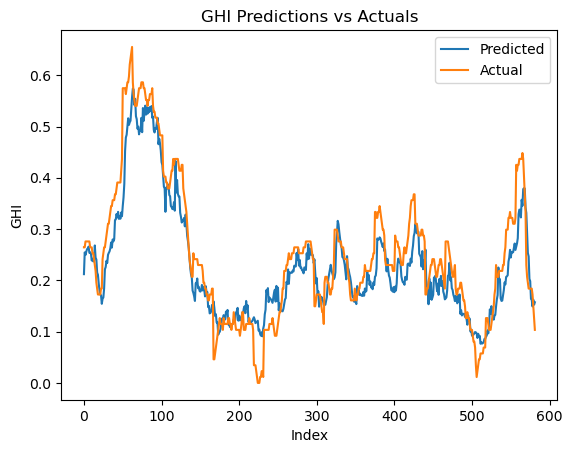

,GHI Predictions,GHI Actuals
0,0.212085,0.264368
1,0.254467,0.264368
2,0.249494,0.275862
3,0.255923,0.275862
4,0.260845,0.275862
...,...,...
577,0.161776,0.183908
578,0.149103,0.172414
579,0.162270,0.149425
580,0.152454,0.126437


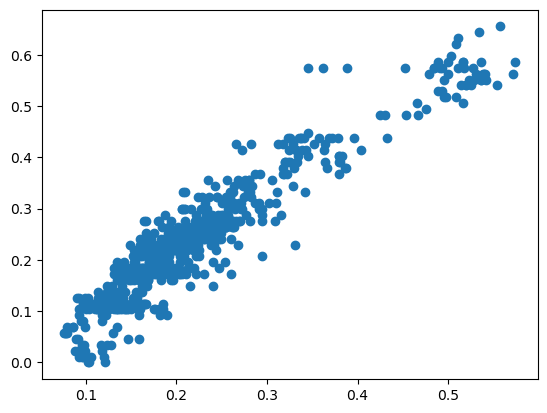

In [104]:
plot_predictions2(model15, X_test, Y_test)